<a href="https://colab.research.google.com/github/BishoyAbd/CV-projec-v1_1/blob/master/Cv_Project%20%7C%20Emotion%20Detector%20v1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          10472        319  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           5881        180  0.9705882        
mohamedharris/supermart-grocery-sales-retail-analytics-dataset  Supermart Grocery Sales - Retail Analytics Dataset  191KB  2022-06-12 16:14:44           

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 96% 274M/285M [00:01<00:00, 155MB/s]
100% 285M/285M [00:02<00:00, 147MB/s]


In [ ]:
!mkdir data
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d data

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: data/example_submission.csv  
  inflating: data/fer2013.tar.gz     
  inflating: data/icml_face_data.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch as pt
import torchvision
import torch.nn as nn

from torchvision.datasets import KMNIST

from  torch.utils.data import random_split, DataLoader
import torchvision.transforms as trans
import torch.optim as optim

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import argparse
import pandas as pd
import time

from PIL import Image


In [ ]:
###################just for tests not used##################
# train=pd.read_csv("/content/data/train.csv")
# test=pd.read_csv("/content/data/test.csv" )
# print(train['emotion'].unique())
# print(train['emotion'][1])
# train.head()

In [ ]:
# train['pixels']=train['pixels'].astype('string')
# img=np.fromstring(train['pixels'][0],np.float32 ,sep=' ')
# plt.imshow(img.reshape(48,48))

In [ ]:
class FaceDataSet(pt.utils.data.Dataset):

  def __init__(self,csv_file,transform=None):
    self.data=pd.read_csv(csv_file)
    # convert obj col to string
    self.data['pixels']= self.data['pixels'].astype('string')
    self.data=self.data[(self.data['emotion']==3 )| (self.data['emotion']==4) | (self.data['emotion']==6 ) ].reset_index()
    self.data['emotion'].replace({3:0,4:1,6:2}, inplace=True)
    self.data.drop('index', inplace=True, axis=1)
    self.transform=transform
    
  def __len__ (self,):
    return len(self.data['pixels'])
    

  def __getitem__(self,idx):
    item=np.fromstring(self.data['pixels'][idx], sep=' ').reshape(48,48)/255
    y=self.data['emotion'][idx]

    if self.transform:
      item=self.transform(item)

    return item,y




In [ ]:
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
# device="cpu"

In [ ]:
transforms=trans.Compose([trans.ToTensor()])

train_ds=FaceDataSet("/content/data/train.csv", transforms)
# test_ds=FaceDataSet("/content/data/test.csv", transforms)

BATCH_SIZE=32
lr=.001
batch_size=64
epochs =50

train_split=.75
valid_split=1-train_split


num_train = int(len(train_ds) * train_split) + 1
num_valid = int(len(train_ds) * valid_split)

train_ds,valid_ds=pt.utils.data.random_split(train_ds,[num_train ,num_valid], generator=pt.Generator().manual_seed(40))
train_loader=pt.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=pt.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE)
# test_loader=pt.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE)


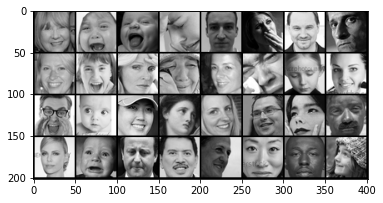

In [ ]:
sample=next(iter(train_loader))
imgs,labels=sample
images= torchvision.utils.make_grid(imgs)
plt.imshow(np.transpose(images, (1,2,0)))
#  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

# 1. Model 

In [ ]:
class EmotionDetector(nn.Module):
  def __init__(self, in_ch,classes):
    super(EmotionDetector,self).__init__()

    self.conv1=nn.Conv2d(in_channels=in_ch,out_channels=60, kernel_size=(3,3))
    self.relu1=nn.ReLU()
    self.bn1=nn.BatchNorm2d(60)
    self.maxPool1=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))


    self.conv2=nn.Conv2d(in_channels=60,out_channels=120, kernel_size=(3,3))
    self.relu2=nn.ReLU()
    self.bn2=nn.BatchNorm2d(120)
    self.maxPool2=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))


    self.conv3=nn.Conv2d(in_channels=120,out_channels=240, kernel_size=(3,3))
    self.relu3=nn.ReLU()
    self.bn3=nn.BatchNorm2d(240)
    # self.maxPool3=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    #28*28*1 -> 27-13-> 12-6 *80 -> 5*4*100
    #    
    self.dropout=nn.Dropout2d()

    self.conv4=nn.Conv2d(in_channels=240,out_channels=480, kernel_size=(3,3))
    self.relu4=nn.ReLU()
    self.maxPool4=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))



    # self.conv5=nn.Conv2d(in_channels=120,out_channels=150, kernel_size=(5,5))
    # self.relu5=nn.ReLU()
    # self.maxPool5=nn.MaxPool2d(kernel_size=(2,2), stride=(1,1))


    self.fc1=nn.Linear(in_features=480*3*3,out_features=200)
    self.relu_fc1=nn.ReLU()

    self.fc2=nn.Linear(in_features=200,out_features=classes)
    self.lsm=nn.LogSoftmax(dim=1)

  def forward(self,x):
    debug=False
    x=x.float()
    if debug : print("input to cv1 ",x.shape)
    x=self.conv1(x)
    if debug : print("input to mxp1",x.shape)
    x=self.bn1(x)
    x=self.relu1(x)
    x=self.maxPool1(x)
    x=self.dropout(x)


    if debug :print("input to cv2",x.shape)
    x=self.conv2(x)
    x=self.bn2(x)

    if debug : print("input to mxp2",x.shape)
    x=self.relu2(x)
    x=self.maxPool2(x)
    x=self.dropout(x)

    if debug : print("input to cv3",x.shape)
    x=self.conv3(x)
    x=self.bn3(x)
    x=self.relu3(x)
    if debug : print("input to mxp3",x.shape)
    # x=self.maxPool3(x)
    x=self.dropout(x)

    
    x=self.conv4(x)
    x=self.relu4(x)
    x=self.maxPool4(x)

    # x=self.conv5(x)
    # x=self.relu5(x)
    # x=self.maxPool5(x)

    if debug : print("input to fc1",x.shape)
    x = pt.flatten(x,1)
    
    x=self.fc1(x)
    x=self.relu_fc1(x)
    if debug : print("input to fc2 ",x.shape)
    x=self.fc2(x)
    if debug : print("input to lsm ",x.shape)
    output=self.lsm(x)
    if debug : print("final output ",x.shape)
    return output

# 2. Train the Model

## load and transfrom data

In [ ]:
train_steps = len(train_loader.dataset) // batch_size
valid_steps = len(valid_loader.dataset) // batch_size
print ("train is {}\nvalidation is {}".format(train_steps,valid_steps))

train is 199
validation is 66


In [ ]:
CLASSES=3
model=EmotionDetector(in_ch=1,classes=CLASSES).to(device)

optimizer=optim.Adam(model.parameters(),lr=lr)

loss_fn=nn.NLLLoss()

obervations = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}


In [ ]:
# train 
for ep in range(0, epochs):
  
  model.train()

  total_train_loss=0
  total_valid_loss=0

  train_correct=0
  valid_correct=0

  for (x,y) in train_loader:
    
    x,y= (x.to(device), y.to(device) )
    
    pred= model(x)
    loss=loss_fn(pred,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_train_loss+=loss.item()

    train_correct+= (pred.argmax(1)==y).type(pt.float).sum().item()


  with pt.no_grad():
      model.eval()

      for (x,y) in valid_loader:
         x,y= (x.to(device), y.to(device) )
         
         pred=model(x)
         total_valid_loss+=loss_fn(pred,y)

         valid_correct+= (pred.argmax(1)==y).type(pt.float).sum().item()

  avg_train_loss=total_train_loss/train_steps
  avg_valid_loss= total_valid_loss/valid_steps

  train_correct=train_correct/len(train_loader.dataset)
  valid_correct=valid_correct/len(valid_loader.dataset)


  # update our training history
  obervations["train_loss"].append(avg_train_loss)
  obervations["train_acc"].append(train_correct)
  obervations["val_loss"].append(avg_valid_loss)
  obervations["val_acc"].append(valid_correct)
  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(ep + 1, epochs))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
  print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format( avg_valid_loss, valid_correct))  

[INFO] EPOCH: 1/50
Train loss: 2.042691, Train accuracy: 0.4838
Val loss: 1.750950, Val accuracy: 0.5814

[INFO] EPOCH: 2/50
Train loss: 1.737726, Train accuracy: 0.5824
Val loss: 1.599918, Val accuracy: 0.6171

[INFO] EPOCH: 3/50
Train loss: 1.641645, Train accuracy: 0.6100
Val loss: 1.571529, Val accuracy: 0.6336

[INFO] EPOCH: 4/50
Train loss: 1.578961, Train accuracy: 0.6293
Val loss: 1.511954, Val accuracy: 0.6373

[INFO] EPOCH: 5/50
Train loss: 1.538579, Train accuracy: 0.6365
Val loss: 1.466110, Val accuracy: 0.6623

[INFO] EPOCH: 6/50
Train loss: 1.498729, Train accuracy: 0.6561
Val loss: 1.509389, Val accuracy: 0.6508

[INFO] EPOCH: 7/50
Train loss: 1.455385, Train accuracy: 0.6631
Val loss: 1.460640, Val accuracy: 0.6616

[INFO] EPOCH: 8/50
Train loss: 1.427562, Train accuracy: 0.6750
Val loss: 1.403110, Val accuracy: 0.6710

[INFO] EPOCH: 9/50
Train loss: 1.414213, Train accuracy: 0.6775
Val loss: 1.395568, Val accuracy: 0.6726

[INFO] EPOCH: 10/50
Train loss: 1.395421, Trai

# Second part (Emotions detection model)